# Imports

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler

# Dataset

## Import

In [2]:
DB_PATH = "datasets/train_houses.db"
CONN = sqlite3.connect(DB_PATH)

query = "SELECT * FROM train_houses;"
df = pd.read_sql_query(query, CONN)
CONN.close()

df = df.astype(str).replace(
    ['', ' ', 'NaN', 'nan', 'NULL', 'None', 'null', '-', '--'],
    np.nan
)

numeric_cols = [
    'Area',
    'Frontage',
    'TotalFloorArea',
    'BuildingYear',
    'Breadth',
    'CoverageRatio',
    'FloorAreaRatio',
    'UnitPrice',
    'PricePerTsubo',
    'TradePrice',
    'MinTimeToNearestStation',
    'MaxTimeToNearestStation',
    'TimeToNearestStation'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.extract(r'(\d+\.?\d*)')[0]
            .astype(float)
        )

dtype_map = {
    'MunicipalityCode': 'int64',
    'AreaIsGreaterFlag': 'int64',
    'FrontageIsGreaterFlag': 'int64',
    'TotalFloorAreaIsGreaterFlag': 'int64',
    'PrewarBuilding': 'int64',
    'Year': 'int64',
    'Quarter': 'int64'
}

df = df.astype(dtype_map, errors='ignore')

print(df.dtypes)


Type                            object
Region                          object
MunicipalityCode                 int64
Prefecture                      object
Municipality                    object
DistrictName                    object
NearestStation                  object
TimeToNearestStation           float64
MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
FloorPlan                       object
Area                           float64
AreaIsGreaterFlag                int64
UnitPrice                      float64
PricePerTsubo                  float64
LandShape                       object
Frontage                       float64
FrontageIsGreaterFlag           object
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
PrewarBuilding                   int64
Structure                       object
Use                             object
Purpose                         object
Direction                

## Analysis and Data Cleaning I

In [3]:
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'unique_values': df.nunique(),
    'missing_percent': df.isna().mean() * 100
}).sort_values('unique_values')

summary['drop_reason'] = np.where(
    summary['unique_values'] == 1, 'Single value',
    np.where(summary['missing_percent'] > 90, 'Null values', '')
)

print(summary)
print("\nCorrelation between UnitPrice and PricePerTsubo:")
print(df[['UnitPrice', 'PricePerTsubo']].corr())

                               dtype  unique_values  missing_percent  \
Prefecture                    object              1         0.000000   
AreaIsGreaterFlag              int64              2         0.000000   
TotalFloorAreaIsGreaterFlag    int64              2         0.000000   
FrontageIsGreaterFlag         object              2         0.000000   
PrewarBuilding                 int64              2         0.000000   
Renovation                    object              2        58.980815   
Quarter                        int64              4         0.000000   
Region                        object              4        45.518662   
Type                          object              5         0.000000   
Purpose                       object              6        61.199963   
CoverageRatio                float64              6         1.430548   
LandShape                     object              9        45.616430   
Direction                     object              9        45.62

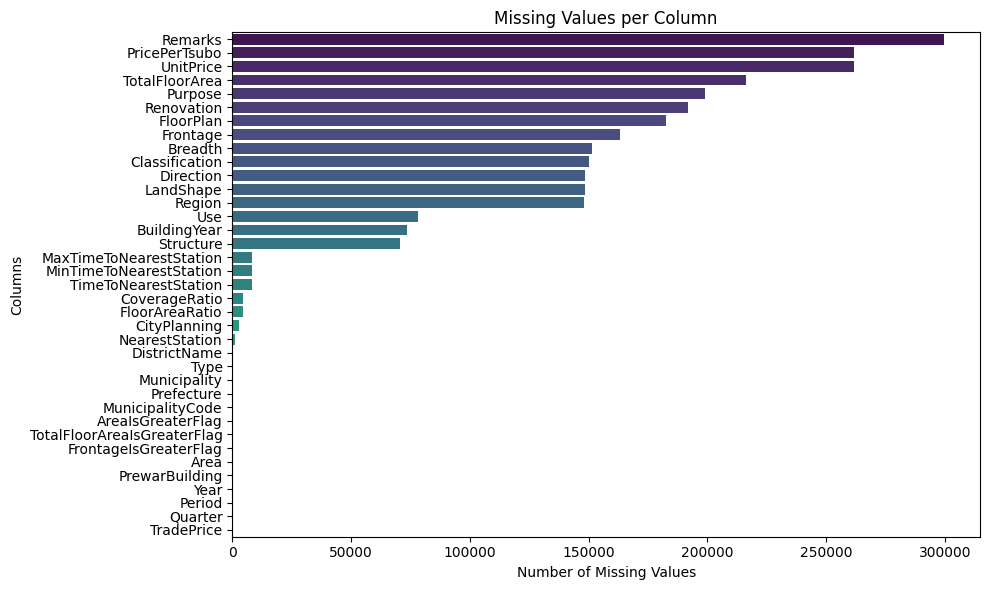

In [4]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Column': missing.index, 'MissingValues': missing.values, 'Percent(%)': missing_percent})
missing_df = missing_df.sort_values(by='MissingValues', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=missing_df,
    x='MissingValues',
    y='Column',
    hue='Column',
    palette='viridis',
    legend=False
)
plt.title('Missing Values per Column')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()

In [5]:
drop_cols = [
    'No',
    'Remarks',
    'Period',
    'Region',
    'Prefecture',
    'Municipality',
    'CityPlanning',
    'Frontage',
    'TotalFloorArea',
    'PrewarBuilding',
    'PricePerTsubo',
    'FrontageIsGreaterFlag',
    'DistrictName',
    'NearestStation',
    'Use',
    'LandShape',
    'Structure',
    'Classification',
    'FloorPlan',
    'Direction'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])

## Analysis and Data Cleaning II

In [6]:
df_encoded = pd.get_dummies(df, drop_first=True)

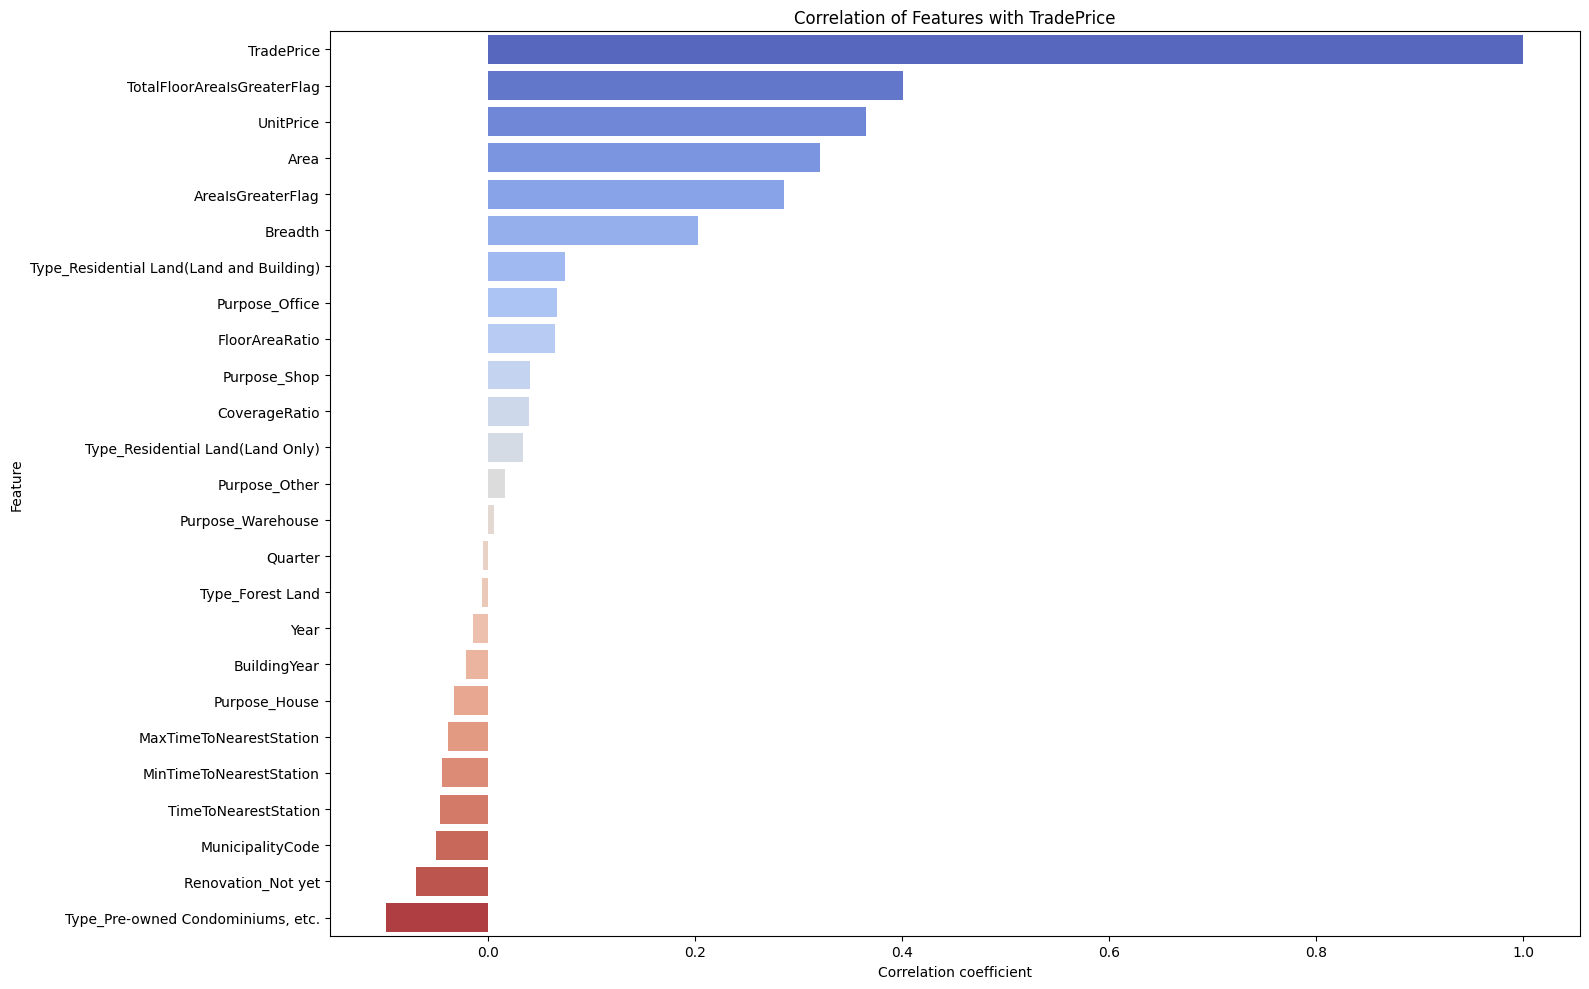

In [7]:
warnings.filterwarnings("ignore", category=FutureWarning)

corr_target = df_encoded.corrwith(df_encoded['TradePrice']).sort_values(ascending=False)

plt.figure(figsize=(16,10))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title('Correlation of Features with TradePrice')
plt.xlabel('Correlation coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

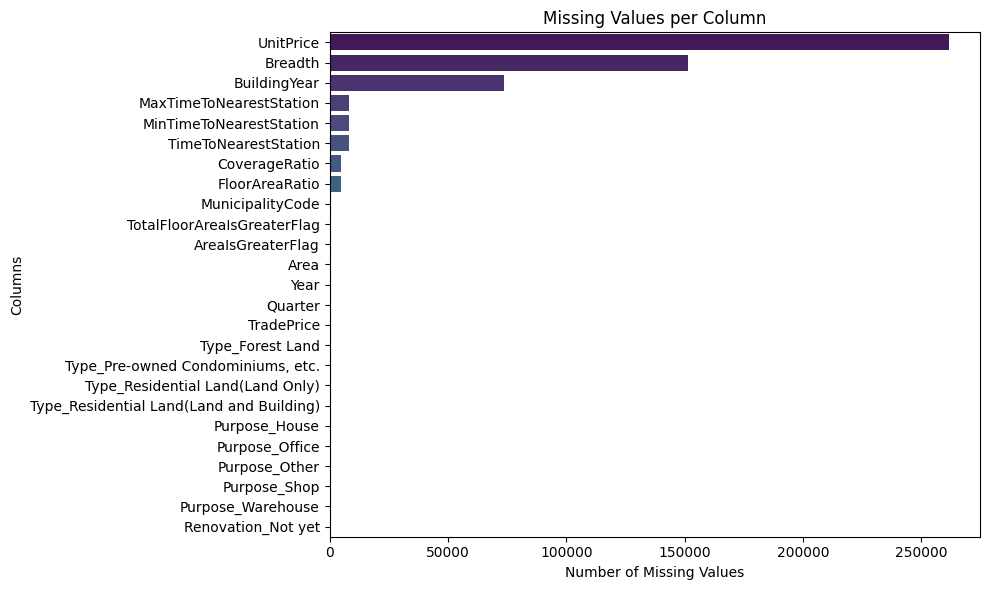

In [8]:
missing = df_encoded.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Column': missing.index, 'MissingValues': missing.values, 'Percent(%)': missing_percent})
missing_df = missing_df.sort_values(by='MissingValues', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=missing_df,
    x='MissingValues',
    y='Column',
    hue='Column',
    palette='viridis',
    legend=False
)
plt.title('Missing Values per Column')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()

In [9]:
drop_cols = ['UnitPrice',  'Quarter', 'Year', 'Breadth']

df_encoded = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns])

df_encoded = df_encoded.dropna().reset_index(drop=True)

print("Dataset shape after dropping columns and nulls:", df_encoded.shape)
df_encoded.info()

Dataset shape after dropping columns and nulls: (242566, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242566 entries, 0 to 242565
Data columns (total 21 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   MunicipalityCode                          242566 non-null  int64  
 1   TimeToNearestStation                      242566 non-null  float64
 2   MinTimeToNearestStation                   242566 non-null  float64
 3   MaxTimeToNearestStation                   242566 non-null  float64
 4   Area                                      242566 non-null  float64
 5   AreaIsGreaterFlag                         242566 non-null  int64  
 6   TotalFloorAreaIsGreaterFlag               242566 non-null  int64  
 7   BuildingYear                              242566 non-null  float64
 8   CoverageRatio                             242566 non-null  float64
 9   FloorAreaRatio                 

## Analysis and Data Cleaning III

Binary (dummy) columns: 2
Continuous numeric columns: 8

Top 10 most imbalanced binary features:
                        Column  PositiveRatio
1  TotalFloorAreaIsGreaterFlag       0.003863
0            AreaIsGreaterFlag       0.001257


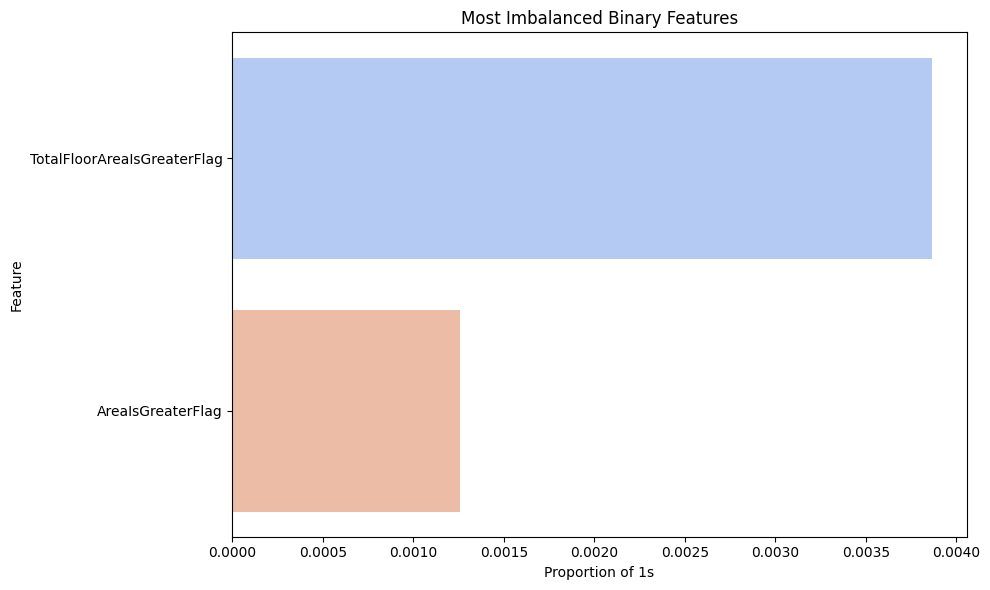

In [10]:

num_cols = df_encoded.select_dtypes(include=['number']).columns.drop('TradePrice', errors='ignore')

binary_cols = [col for col in num_cols if set(df_encoded[col].dropna().unique()).issubset({0, 1})]
cont_cols = [col for col in num_cols if col not in binary_cols]

print(f"Binary (dummy) columns: {len(binary_cols)}")
print(f"Continuous numeric columns: {len(cont_cols)}")

imbalance_report = []
for col in binary_cols:
    ratio = df_encoded[col].mean()
    imbalance_report.append((col, ratio))

imbalance_df = pd.DataFrame(imbalance_report, columns=['Column', 'PositiveRatio']).sort_values('PositiveRatio', ascending=False)

print("\nTop 10 most imbalanced binary features:")
print(imbalance_df.head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=imbalance_df.head(15), x='PositiveRatio', y='Column', palette='coolwarm')
plt.title('Most Imbalanced Binary Features')
plt.xlabel('Proportion of 1s')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [11]:
drop_cols = ['AreaIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag']

df_encoded = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns])

Motivo das exclusões realizadas a partir do dicionário de dados e de válidações:
| Coluna | Motivo |
|:--|:--|
| `No` | Identificador do imóvel |
| `Remarks` | Campo descritivo |
| `Period` | Informação duplicada, uma vez que já consta em Year e Quarter |
| `Region` | Informação genérica |
| `Prefecture` | Valor constante como "Tokyo". |
| `Municipality` | Substituída por `MunicipalityCode`, que representa a mesma informação de forma numérica. |
| `CityPlanning` | Quase constante no dataset, pouca variabilidade. |
| `Frontage` | Alta taxa de valores ausentes |
| `TotalFloorArea` | Alta taxa de valores ausentes, substituída pela flag `TotalFloorAreaIsGreaterFlag`. |
| `PrewarBuilding` | Já representado pela variável BuildingYear |
| `PricePerTsubo` | Colinear com UnitPrice |
| `FrontageIsGreaterFlag` | Valor unitário |
| `DistrictName` | Dado tipo texto com alta cardinalidade |
| `NearestStation` | Dado tipo texto com alta cardinalidade |
| `Use` | Dado tipo texto com alta cardinalidade |
| `Structure` | Dado tipo texto com alta cardinalidade |
| `Classification` | Dado tipo texto com alta cardinalidade |
| `Landshape` | Dado tipo texto com alta cardinalidade |
| `FloorPlan` | Dado tipo texto com alta cardinalidade |
| `Direction` | Dado tipo texto com alta cardinalidade |
| `AreaIsGreaterFlag` | Variável binária desbalanceada |
| `TotalFloorAreaIsGreaterFlag` | Variável binária desbalanceada |
| `UnitPrice` | Alta proporção de nulos |
| `Breadth` | Alta proporção de nulos |
| `Quarter` | Baixa correlação |
| `Year` | Baixa correlação |

# Data Preparation for Model Training

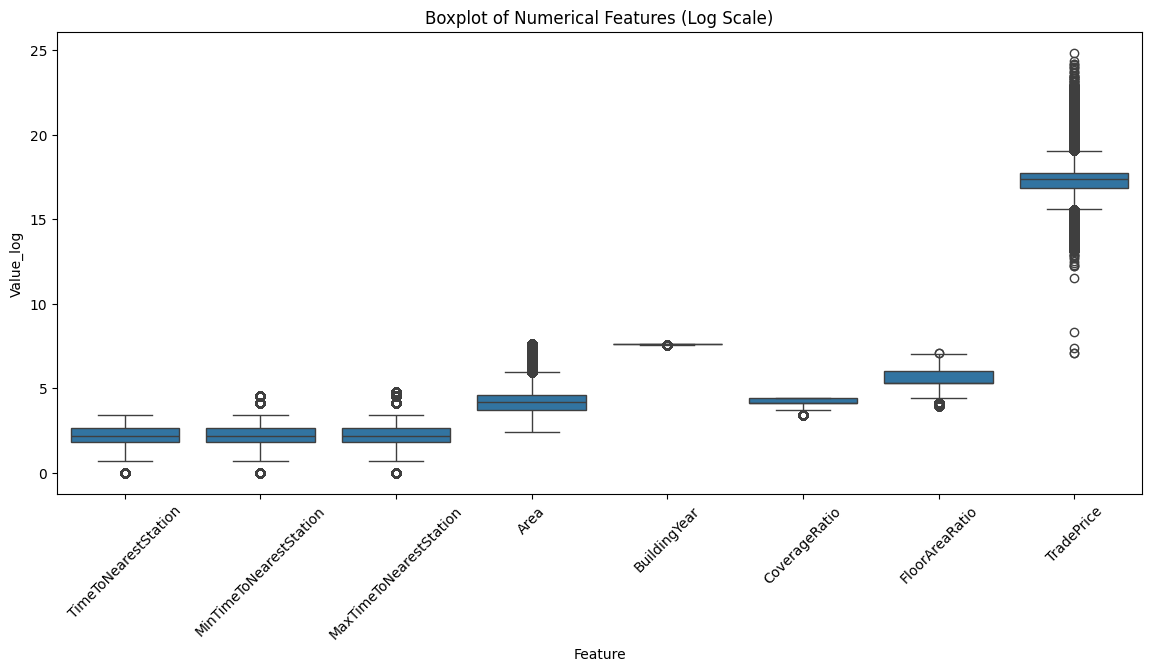

In [12]:
num_cols = ['TimeToNearestStation', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
            'Area', 'BuildingYear', 'CoverageRatio', 'FloorAreaRatio', 'TradePrice']

df_melted = df_encoded[num_cols].melt(var_name='Feature', value_name='Value')

df_melted['Value_log'] = np.log1p(df_melted['Value'])

plt.figure(figsize=(14,6))
sns.boxplot(x='Feature', y='Value_log', data=df_melted)
plt.xticks(rotation=45)
plt.title('Boxplot of Numerical Features (Log Scale)')
plt.show()

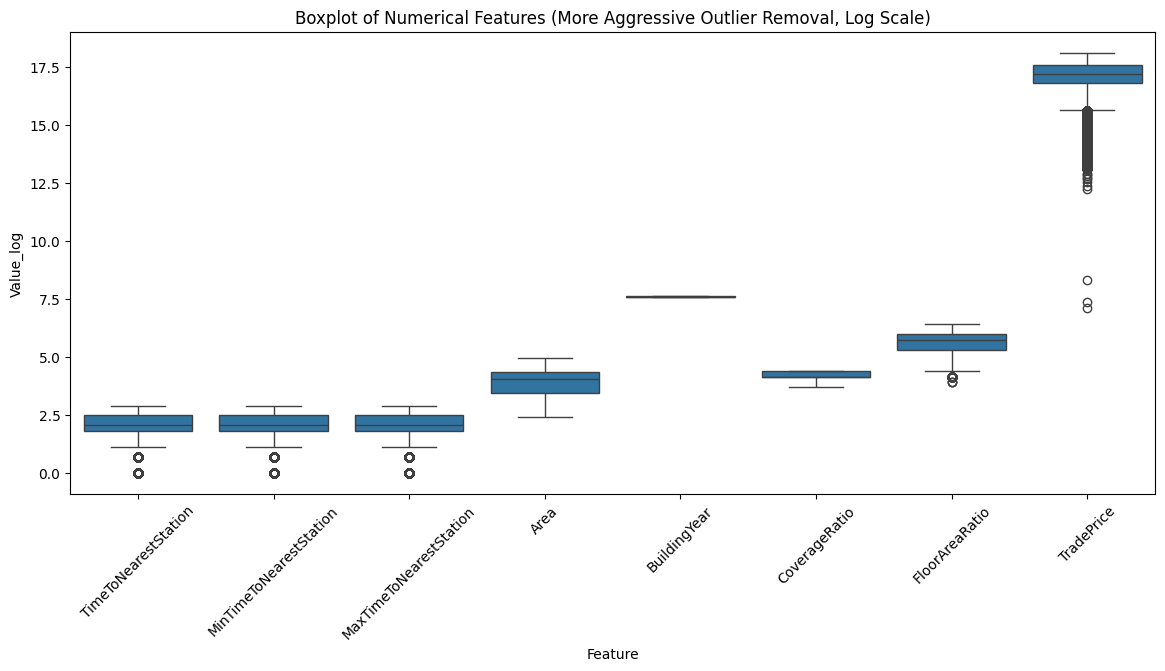

In [13]:
num_cols = ['TimeToNearestStation', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
            'Area', 'BuildingYear', 'CoverageRatio', 'FloorAreaRatio', 'TradePrice']

for col in num_cols:
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR
    df_encoded = df_encoded[(df_encoded[col] >= lower_bound) & (df_encoded[col] <= upper_bound)]

df_melted = df_encoded[num_cols].melt(var_name='Feature', value_name='Value')
df_melted['Value_log'] = np.log1p(df_melted['Value'])

plt.figure(figsize=(14,6))
sns.boxplot(x='Feature', y='Value_log', data=df_melted)
plt.xticks(rotation=45)
plt.title('Boxplot of Numerical Features (More Aggressive Outlier Removal, Log Scale)')
plt.show()

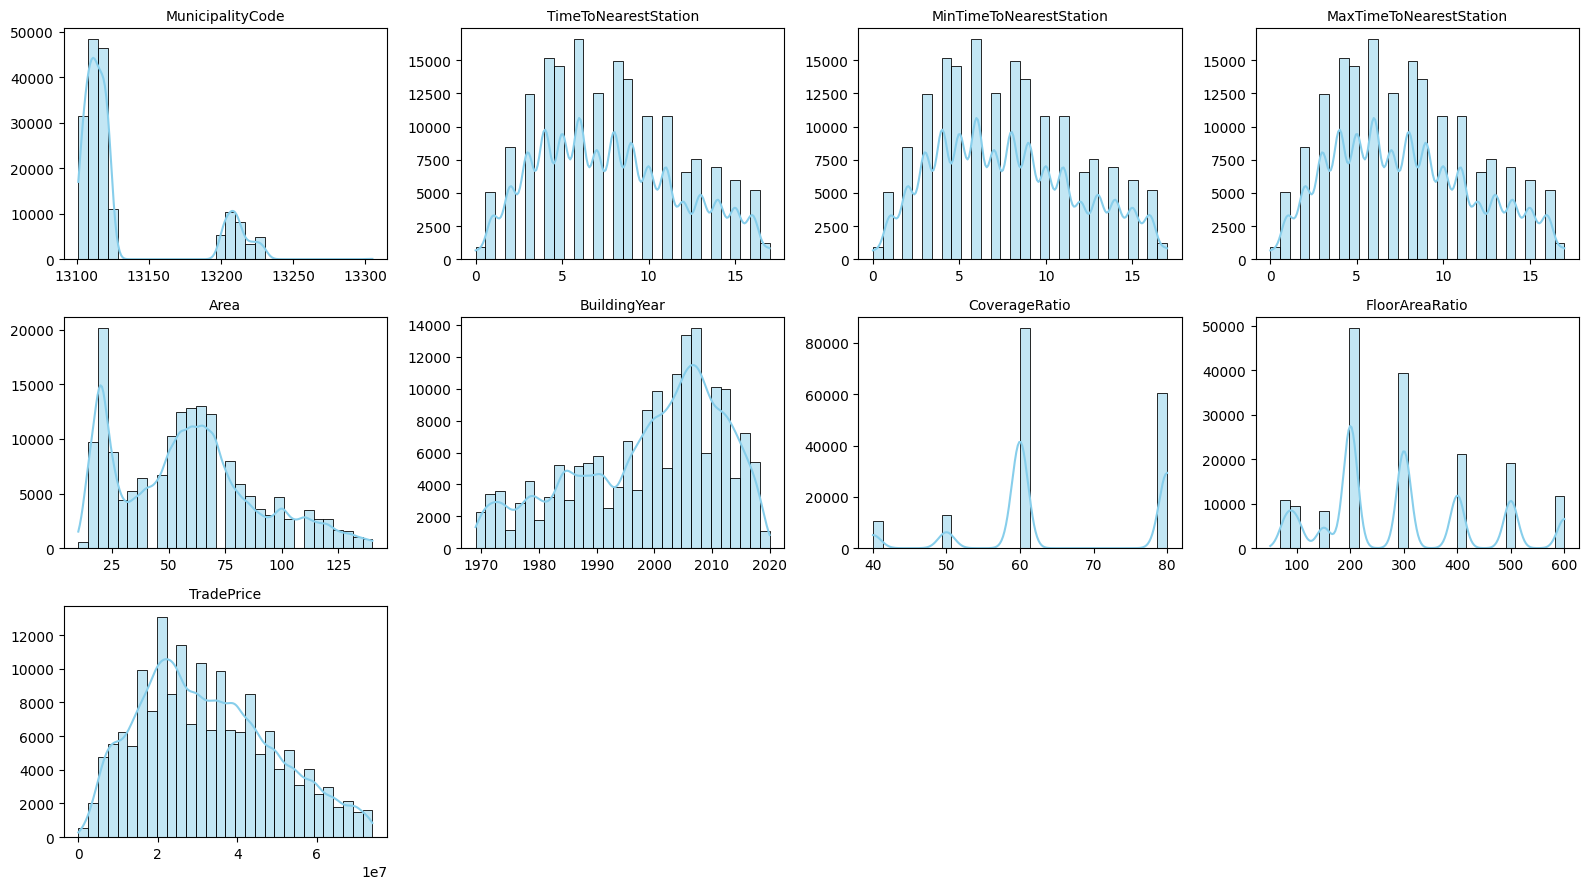

In [14]:
numerical_columns = df_encoded.select_dtypes(include=['number']).columns
n_cols = 4
n_rows = math.ceil(len(numerical_columns) / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, column in enumerate(numerical_columns):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_encoded[column], kde=True, bins=30, color='skyblue')
    ax.set_title(column, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [15]:
df_encoded.columns = (
    df_encoded.columns
    .str.strip()
    .str.replace(' ', '_', regex=True)
    .str.replace('[.,]', '', regex=True)
)

Feature engineering:
- Transformações logarítmicas nas variáveis Area, CoverageRatio e FloorAreaRatio para reduzir a assimetria e facilitar padrões consistentes.
- Criação de interações entre Area e CoverageRatio e entre Area e FloorAreaRatio, para capturar efeitos não lineares.

In [16]:
df_encoded['Area_log'] = np.log1p(df_encoded['Area'])
df_encoded['CoverageRatio_log'] = np.log1p(df_encoded['CoverageRatio'])
df_encoded['FloorAreaRatio_log'] = np.log1p(df_encoded['FloorAreaRatio'])
df_encoded['Area_Coverage'] = df_encoded['Area'] * df_encoded['CoverageRatio']
df_encoded['Area_FAR'] = df_encoded['Area'] * df_encoded['FloorAreaRatio']

# Training

In [17]:
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=['TradePrice'])
y_train = train_df[['TradePrice']]
X_test = test_df.drop(columns=['TradePrice'])
y_test = test_df[['TradePrice']]

num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

scaler_num = RobustScaler()
X_train[num_cols] = scaler_num.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler_num.transform(X_test[num_cols])

def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

lr_model = LinearRegression()
lr_mae, lr_rmse, lr_r2 = train_evaluate(lr_model, X_train, y_train, X_test, y_test)

rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_mae, rf_rmse, rf_r2 = train_evaluate(rf_model, X_train, y_train, X_test, y_test)

xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_mae, xgb_rmse, xgb_r2 = train_evaluate(xgb_model, X_train, y_train, X_test, y_test)

lgb_model = lgb.LGBMRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1)
lgb_mae, lgb_rmse, lgb_r2 = train_evaluate(lgb_model, X_train, y_train, X_test, y_test)

print("Linear Regression:")
print(f"MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}, R²: {lr_r2:.4f}\n")
print("Random Forest Regressor:")
print(f"MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}\n")
print("XGBoost Regressor:")
print(f"MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}\n")
print("LightGBM Regressor:")
print(f"MAE: {lgb_mae:.2f}, RMSE: {lgb_rmse:.2f}, R²: {lgb_r2:.4f}\n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 135540, number of used features: 21
[LightGBM] [Info] Start training from score 32315184.571344
Linear Regression:
MAE: 7331454.88, RMSE: 9678524.30, R²: 0.6586

Random Forest Regressor:
MAE: 4770641.37, RMSE: 6769079.75, R²: 0.8330

XGBoost Regressor:
MAE: 4719700.00, RMSE: 6653864.38, R²: 0.8387

LightGBM Regressor:
MAE: 4745790.93, RMSE: 6671558.91, R²: 0.8378



| Model                     | MAE          | RMSE         | R²      |
|----------------------------|--------------|--------------|---------|
| Linear Regression          | 7,331,454.88 | 9,678,524.30 | 0.6586  |
| Random Forest Regressor    | 4,770,641.37 | 6,769,079.75 | 0.8330  |
| XGBoost Regressor          | 4,719,700.00 | 6,653,864.38 | 0.8387  |
| LightGBM Regressor         | 4,745,790.93 | 6,671,558.91 | 0.8378  |

# Avaliation

Visualização da correspondência entre valores previstos e reais para avaliar a precisão do modelo e identificar desvios sistemáticos:

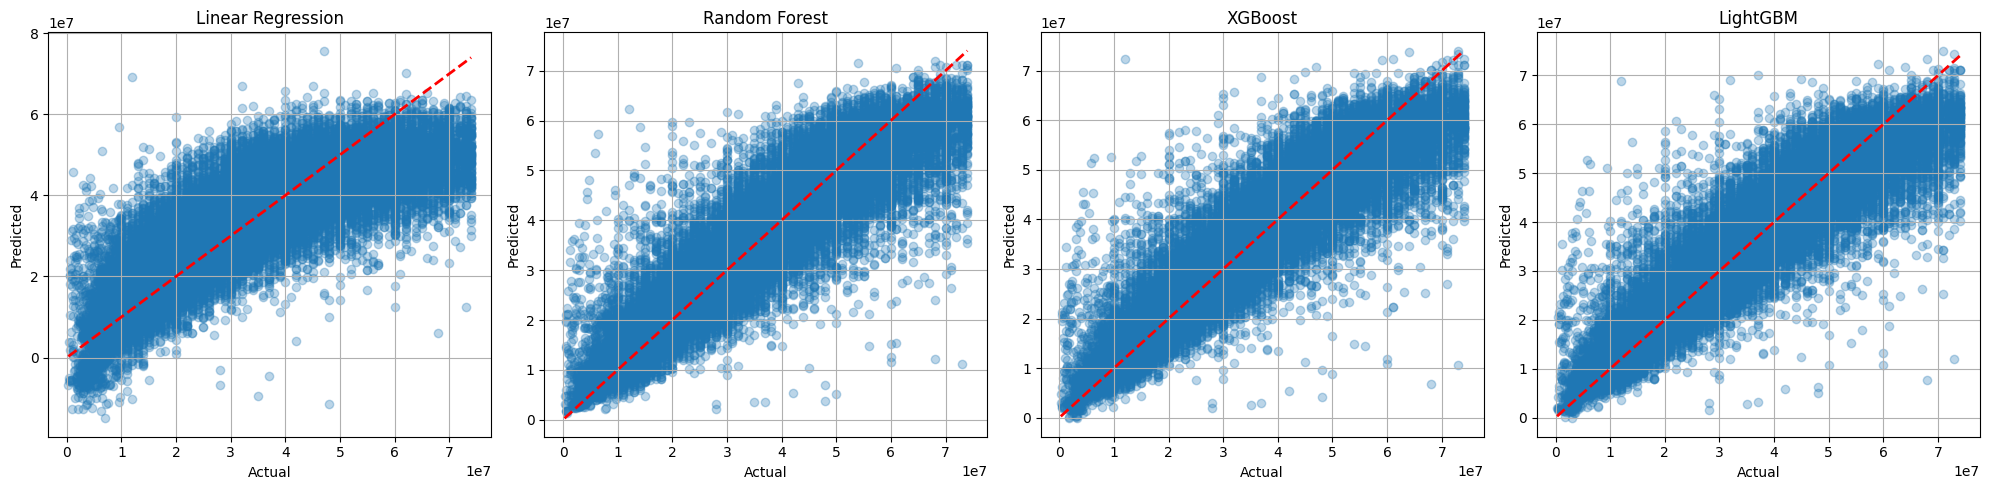

In [18]:
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM']
preds = [y_pred_lr, y_pred_rf, y_pred_xgb, y_pred_lgb]

plt.figure(figsize=(20,5))

for i, (model_name, y_pred) in enumerate(zip(models, preds), 1):
    plt.subplot(1, 4, i)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(model_name)
    plt.grid(True)

plt.tight_layout()
plt.show()

Avaliação da amplitude do erro para identificar a concentração e a dispersão dos resíduos do modelo:

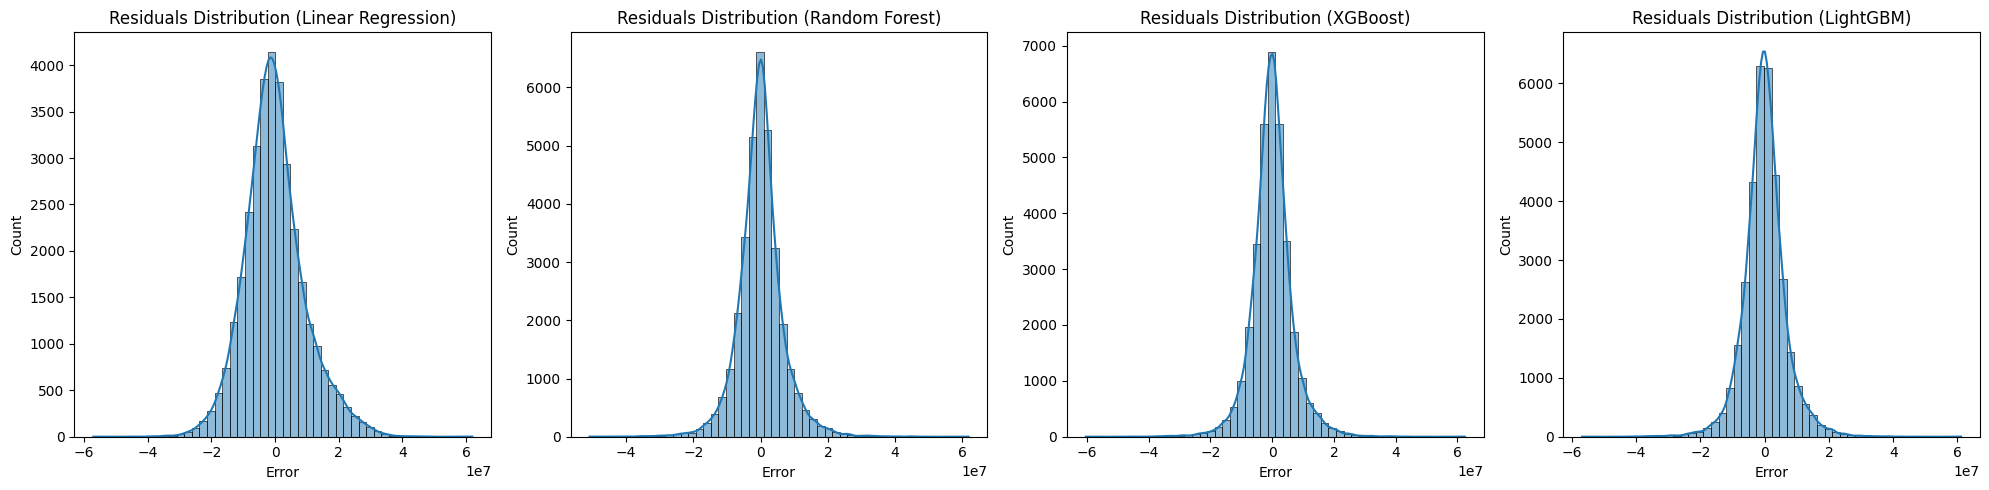

In [19]:
models = {
    'Linear Regression': lr_model.predict(X_test),
    'Random Forest': rf_model.predict(X_test),
    'XGBoost': xgb_model.predict(X_test),
    'LightGBM': lgb_model.predict(X_test)
}

plt.figure(figsize=(20,5))
for i, (name, y_pred) in enumerate(models.items(), 1):
    residuals = y_test.values.ravel() - y_pred
    plt.subplot(1, 4, i)
    sns.histplot(residuals, bins=50, kde=True)
    plt.title(f'Residuals Distribution ({name})')
    plt.xlabel('Error')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Training with XGBoost

O XGBoost, modelo de boosting baseado em árvores capaz de capturar relações não lineares complexas e lidar melhor com outliers e interações entre variáveis

Nos testes realizados, o XGBoost apresentou o melhor desempenho entre os quatro modelos avaliados, e por isso seguiu-se com ele.

In [20]:
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=['TradePrice'])
y_train = train_df[['TradePrice']]
X_test = test_df.drop(columns=['TradePrice'])
y_test = test_df[['TradePrice']]

num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=2
)

grid_search.fit(X_train, y_train.values.ravel())

xgb_model = grid_search.best_estimator_

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test.clip(lower=0), np.maximum(0, y_pred)))
mape = np.mean(np.abs((y_test.values.ravel() - y_pred) / y_test.values.ravel())) * 100

print("Best XGBoost parameters:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"RMSLE: {rmsle:.4f}")
print(f"MAPE: {mape:.2f}%")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_

**Best Parameters:**
```python
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}
```

**Performance Metrics:**

| Metric | Value |
|---------|--------|
| **MAE** | 4,584,758.50 |
| **RMSE** | 6,518,892.09 |
| **R²** | 0.8451 |
| **RMSLE** | 0.2614 |
| **MAPE** | 20.29% |

## XGBoost avaliation

Avaliação das principais features que mais influenciaram as previsões do modelo XGBoost durante o treinamento:

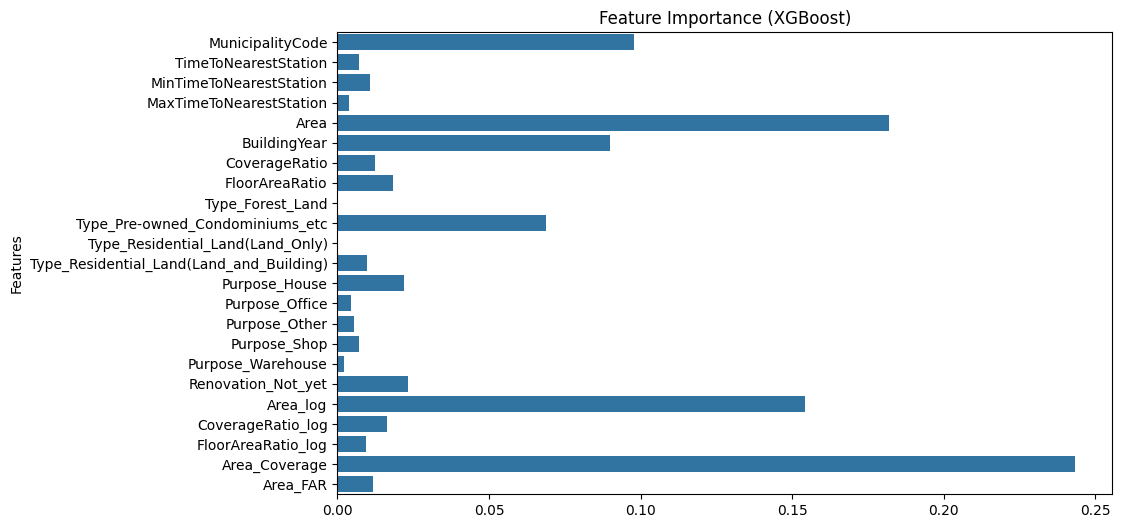

In [29]:
importances = xgb_model.feature_importances_
features = X_test.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.show()

Visualização dos valores previstos versus reais, com os pontos coloridos de acordo com o erro absoluto, destacando áreas onde o modelo XGBoost apresenta maiores discrepâncias:

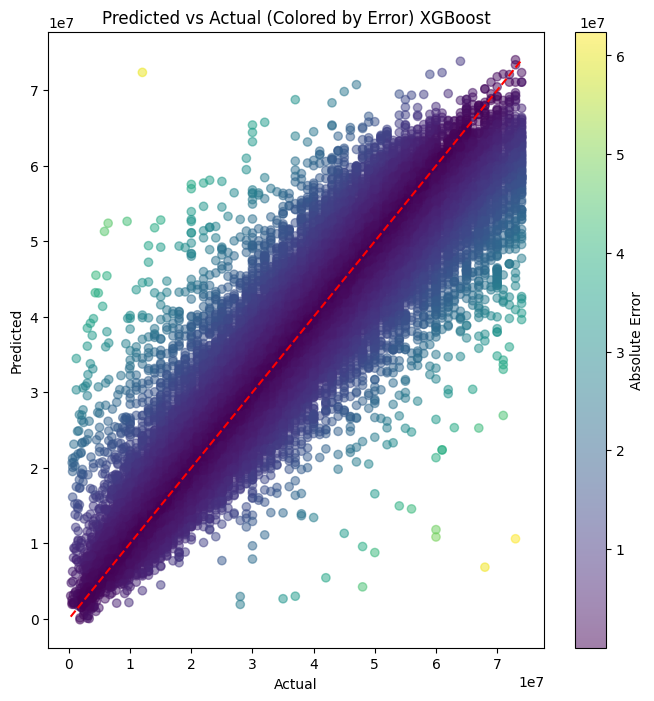

In [30]:
errors = np.abs(y_test.values.ravel() - y_pred_xgb)
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_xgb, c=errors, cmap='viridis', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.colorbar(label='Absolute Error')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual (Colored by Error) XGBoost')
plt.show()

# Predict

## import and preparation

In [31]:
DB_PATH = "datasets/test_houses.db"
CONN = sqlite3.connect(DB_PATH)

query = "SELECT * FROM test_houses;"
df_test = pd.read_sql_query(query, CONN)
CONN.close()

df_test = df_test.astype(str).replace(
    ['', ' ', 'NaN', 'nan', 'NULL', 'None', 'null', '-', '--'],
    np.nan
)

numeric_cols = [
    'Area',
    'Frontage',
    'TotalFloorArea',
    'BuildingYear',
    'Breadth',
    'CoverageRatio',
    'FloorAreaRatio',
    'UnitPrice',
    'PricePerTsubo',
    'TradePrice',
    'MinTimeToNearestStation',
    'MaxTimeToNearestStation',
    'TimeToNearestStation'
]

for col in numeric_cols:
    if col in df_test.columns:
        df_test[col] = (
            df_test[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.extract(r'(\d+\.?\d*)')[0]
            .astype(float)
        )

dtype_map = {
    'MunicipalityCode': 'int64',
    'AreaIsGreaterFlag': 'int64',
    'FrontageIsGreaterFlag': 'int64',
    'TotalFloorAreaIsGreaterFlag': 'int64',
    'PrewarBuilding': 'int64',
    'Year': 'int64',
    'Quarter': 'int64'
}

df_test = df_test.astype(dtype_map, errors='ignore')

df_test['ID'] = np.arange(1, len(df_test) + 1)
df_test_to_predict = df_test.copy()

df_test_encoded = pd.get_dummies(df_test_to_predict, drop_first=False)

train_features = df_encoded.drop(columns=['TradePrice']).columns
for col in train_features:
    if col not in df_test_encoded.columns:
        df_test_encoded[col] = 0

df_test_encoded = df_test_encoded[train_features]
df_test_encoded['ID'] = df_test_to_predict['ID']

summary = pd.DataFrame({
    'dtype': df_test_encoded.dtypes,
    'unique_values': df_test_encoded.nunique(),
    'missing_count': df_test_encoded.isna().sum(),
    'missing_percent': df_test_encoded.isna().mean() * 100
}).sort_values('missing_percent', ascending=False)

print(summary)

                                            dtype  unique_values  \
BuildingYear                              float64             76   
MaxTimeToNearestStation                   float64             33   
MinTimeToNearestStation                   float64             34   
TimeToNearestStation                      float64             31   
FloorAreaRatio                            float64             16   
CoverageRatio                             float64              6   
MunicipalityCode                            int64             59   
Area                                      float64            149   
Type_Forest_Land                            int64              1   
Type_Pre-owned_Condominiums_etc             int64              1   
Type_Residential_Land(Land_Only)            int64              1   
Type_Residential_Land(Land_and_Building)    int64              1   
Purpose_House                                bool              2   
Purpose_Office                               boo

Preenchimento de valores faltantes com mediana

In [32]:
num_fill_cols = [
    'BuildingYear', 
    'MaxTimeToNearestStation', 
    'MinTimeToNearestStation', 
    'TimeToNearestStation', 
    'FloorAreaRatio', 
    'CoverageRatio'
]

for col in num_fill_cols:
    df_test_encoded[col] = df_test_encoded[col].fillna(df_test_encoded[col].median())

## Data prediction

In [33]:
num_cols = df_test_encoded.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('ID')

scaler_num = RobustScaler()

df_test_encoded[num_cols] = scaler_num.fit_transform(df_test_encoded[num_cols])

y_pred_test = xgb_model.predict(df_test_encoded.drop(columns=['ID']))

df_test_to_predict['PredictedTradePrice'] = y_pred_test

print(f"Shape of df: {df_test_to_predict.shape}")
df_test_to_predict.head()

Shape of df: (81314, 39)


,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,...,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice,ID,PredictedTradePrice
0,"Pre-owned Condominiums, etc.",NaN,13103,Tokyo,Minato Ward,Toranomon,Kamiyacho,4.0,4.0,4.0,...,80.0,500.0,3rd quarter 2016,2016,3,Not yet,NaN,NaN,1,41758784.0
1,"Pre-owned Condominiums, etc.",NaN,13110,Tokyo,Meguro Ward,Higashiyama,Ikejiriohashi,7.0,7.0,7.0,...,60.0,300.0,3rd quarter 2012,2012,3,NaN,NaN,NaN,2,33462176.0
2,"Pre-owned Condominiums, etc.",NaN,13112,Tokyo,Setagaya Ward,Kitakarasuyama,Chitosekarasuyama,25.0,25.0,25.0,...,50.0,100.0,4th quarter 2015,2015,4,Done,NaN,NaN,3,39284672.0
3,"Pre-owned Condominiums, etc.",NaN,13121,Tokyo,Adachi Ward,Ayase,Ayase,4.0,4.0,4.0,...,80.0,500.0,2nd quarter 2017,2017,2,Done,NaN,NaN,4,38344068.0
4,Residential Land(Land and Building),Residential Area,13107,Tokyo,Sumida Ward,Honjo,Honjoazumabashi,7.0,7.0,7.0,...,80.0,300.0,3rd quarter 2016,2016,3,NaN,NaN,NaN,5,37800060.0


Join de dados previstos com dataset

In [34]:
df_test = df_test.merge(
    df_test_to_predict[['ID', 'PredictedTradePrice']],
    on='ID',
    how='left'
)

df_test['TradePrice'] = df_test['PredictedTradePrice'].round(0).astype(int)
df_test = df_test.drop(columns=['PredictedTradePrice'])

df_test.head()


,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,...,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice,ID
0,"Pre-owned Condominiums, etc.",NaN,13103,Tokyo,Minato Ward,Toranomon,Kamiyacho,4.0,4.0,4.0,...,Commercial Zone,80.0,500.0,3rd quarter 2016,2016,3,Not yet,NaN,41758784,1
1,"Pre-owned Condominiums, etc.",NaN,13110,Tokyo,Meguro Ward,Higashiyama,Ikejiriohashi,7.0,7.0,7.0,...,Category I Residential Zone,60.0,300.0,3rd quarter 2012,2012,3,NaN,NaN,33462176,2
2,"Pre-owned Condominiums, etc.",NaN,13112,Tokyo,Setagaya Ward,Kitakarasuyama,Chitosekarasuyama,25.0,25.0,25.0,...,Category I Exclusively Low-story Residential Zone,50.0,100.0,4th quarter 2015,2015,4,Done,NaN,39284672,3
3,"Pre-owned Condominiums, etc.",NaN,13121,Tokyo,Adachi Ward,Ayase,Ayase,4.0,4.0,4.0,...,Commercial Zone,80.0,500.0,2nd quarter 2017,2017,2,Done,NaN,38344068,4
4,Residential Land(Land and Building),Residential Area,13107,Tokyo,Sumida Ward,Honjo,Honjoazumabashi,7.0,7.0,7.0,...,Neighborhood Commercial Zone,80.0,300.0,3rd quarter 2016,2016,3,NaN,NaN,37800060,5


## File creation

In [35]:
df_test = df_test.drop(columns=['ID'])

df_test.to_csv("datasets/test_houses_predicted.csv", index=False)